In [ ]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10**3)
pd.set_option('display.max_rows', 10**3)

In [ ]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import gc
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import alphalens
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [ ]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile
# UNSEEN_KEY = '/data/YEAR_20220803_20230803'
top = 250  # parameters -> papermill
DATA_STORE = Path(f'data/{top}_dataset.h5')
with pd.HDFStore(DATA_STORE) as store:
    # unseen = store[UNSEEN_KEY]
    print(store.keys())

In [ ]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile

top = 250  # parameters -> papermill
DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = '/data/YEAR_20200930_20220802'
label_col = 'TARGET_ret_fwd_01d' 
label = label_col + '_rank_quantiled'

with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # print(dataset.index.levels[datetime_level].tz)

# Check and localize the datetime level of the MultiIndex to UTC if needed
datetime_level = 0  # Assuming the datetime is the first level
if dataset.index.levels[datetime_level].tz is None:
    localized_level = dataset.index.levels[datetime_level].tz_localize('UTC')
    dataset.index = dataset.index.set_levels(localized_level, level=datetime_level)

# Applying the rank_stocks_and_quantile function to the dataset
dataset_ranked = rank_stocks_and_quantile(dataset, TARGET_col=label_col)
print(dataset_ranked.info())

del dataset

# Assuming your DataFrame is named df
cols = dataset_ranked.columns.tolist()
# Populate the features list with column names starting with 'feature_'
features = [col for col in cols if col.startswith('FEATURE_')]
# Find the first column starting with 'target_' and set it as the label
label_cols = [col for col in cols if col.startswith('TARGET_')]
print(len(features))  # This will show all the columns starting with 'feature_'
print(label)  # This will show the first column starting with 'target_'

In [ ]:
# features

In [ ]:
label_cols

In [ ]:
target = 'TARGET_ret_fwd_frac_order'
# # Assuming you have your original dataframe named df ready
# alphalens_analysis = generate_alphalens_tearsheet(dataset_ranked, \
#     label_col=target, price_col='FEATURE_close')


# # alphalens_analysis
# import alphalens as al
# al.tears.create_full_tear_sheet(alphalens_analysis)

In [ ]:
dataset_ranked

In [ ]:
dataset_ranked.info()

In [ ]:
## Idea: Convrting returns as a image shapshot: IPCV project
import numpy as np
import math

# Assuming 'dataset_ranked' is your dataframe and has already been loaded into the current workspace.
unique_dates = dataset_ranked.index.get_level_values(0).unique()

images = []

# Determine the dimensions of the 2D image based on the number of tickers.
num_tickers = len(dataset_ranked.index.get_level_values(1).unique())
side_length = math.floor(math.sqrt(num_tickers))  # Largest square less than num_tickers

# Adjust the number of tickers
num_tickers = side_length * side_length

for idx, date in enumerate(unique_dates):
    day_data = dataset_ranked.loc[date].iloc[:num_tickers]  # Keep only the number of rows we need
    
    if all(feature in day_data.columns for feature in \
        ['FEATURE_ret_frac_order', 'FEATURE_ret_01d', 'FEATURE_ret_02d']):
        
        channels = []
        
        for feature in ['FEATURE_ret_frac_order', 'FEATURE_ret_01d', 'FEATURE_ret_02d']:
            # Convert the data to a 2D image representation
            feature_data = day_data[feature].values
            # Reshape it to a square matrix
            feature_image = feature_data.reshape(side_length, side_length)
            channels.append(feature_image)
        
        # Stack the channels to form a multi-channel image
        image = np.stack(channels, axis=-1)
        images.append(image)
    else:
        print(f"Skipping date {date} due to inadequate data.")

print("Number of images:", len(images))
if images:
    print(images[0].shape)  # This should give (side_length, side_length, 3)
else:
    print("No images created.")


In [ ]:
print(images[0].shape)

In [ ]:
from PIL import Image

# Get the first image from the images list
first_image = images[0]

# Scale it to 0-255 range for visualization (useful if your data isn't already in this range)
scaled_image = (first_image - first_image.min()) / (first_image.max() - first_image.min()) * 255
scaled_image = scaled_image.astype(np.uint8)

# Create a PIL image
image_pil = Image.fromarray(scaled_image)

# Display the image
image_pil.show()


In [ ]:
from IPython.display import display


display(image_pil)

In [ ]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# fetch the daily returns for the benchmark (SPY in this case)
benchmark = qs.utils.download_returns('SPY')

# Localize stock and benchmark to UTC (as they are tz-naive)
stock.index = stock.index.tz_localize('UTC')
benchmark.index = benchmark.index.tz_localize('UTC')

# show sharpe ratio
print("Sharpe Ratio:", qs.stats.sharpe(stock))

# or using extend_pandas() :)
print("Sharpe Ratio using extend_pandas:", stock.sharpe())

# Visualize stock performance
qs.plots.snapshot(stock, title='Facebook Performance', show=True)
stock.index = stock.index.tz_localize(None)
benchmark.index = benchmark.index.tz_localize(None)

# Generate HTML report comparing the stock performance against the benchmark
qs.reports.html(stock, benchmark)

[*********************100%***********************]  1 of 1 completed


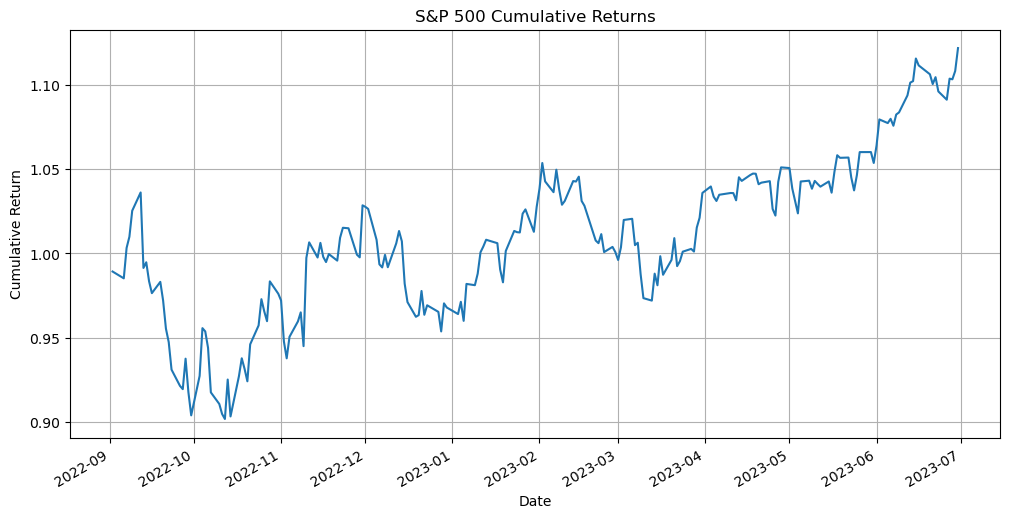

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sp500_cumulative_return(start_date, end_date):
    # Download S&P 500 data
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    
    # Calculate daily returns
    sp500['Daily Return'] = sp500['Adj Close'].pct_change()
    
    # Calculate cumulative returns
    sp500['Cumulative Return'] = (1 + sp500['Daily Return']).cumprod()
    
    # Plot cumulative returns
    plt.figure(figsize=(12,6))
    sp500['Cumulative Return'].plot()
    plt.title('S&P 500 Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

# Define the date range
start_date = '2022-09-01'
end_date = '2023-07-01'

# Plot the cumulative return for S&P 500 in the specified date range
plot_sp500_cumulative_return(start_date, end_date)
